In [9]:
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='1'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
# import torch
import logging
import time
from argparse import ArgumentParser

import cv2
# import json_tricks as json
import numpy as np

from multi_camera.datajoint.sessions import Subject, Session, Recording
from multi_camera.analysis.calibration import plot_cal

from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import Calibration,PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod,PersonKeypointReprojectionVideo,PersonKeypointReconstructionVideo
from multi_camera.datajoint.sessions import Recording
from hand_detection.hand_dj import HandPoseReconstructionMethodLookup,HandPoseReconstructionMethod, HandPoseReconstruction,HandPoseEstimationMethodLookup
from hand_detection.hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo,MJXReconstruction
from hand_detection.hand_dj import MJXReconstructionVideo,MJXReconstructionAnalysis

In [13]:
keys = (HandPoseEstimation & (Recording & f'participant_id="m003"') & 'estimation_method=0' & 'detection_method=1').fetch('KEY')[:8]
# CUDA_VISIBLE_DEVICES=0 python -m multi_camera.datajoint.calibrate_cameras --checkerboard_size=29 --checkerboard_dim=3,6 /mnt/CottonLab/mobile_system_data/20240124/m003/calibration_20240124_143224

In [62]:
 (Calibration & 'recording_base LIKE "%20240124_143040%"')

cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type
2024-01-24 14:30:40,10d8a3c714,calibration_20240124_143040,8,=BLOB=,=BLOB=,0.162555,=BLOB=,=BLOB=,None


In [26]:
# (SingleCameraVideo & f'filename LIKE "{subject_id}_%"')
cal_key = (Calibration & 'recording_base LIKE "%20240124_143040%"').fetch1('KEY')

In [23]:
key = (Calibration&((SingleCameraVideo & f'filename LIKE"{subject_id}%"'))).fetch('KEY')
(Calibration&((SingleCameraVideo & f'filename LIKE "{subject_id}%"')))
# (Calibration&key[-1]).delete()

cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type
2024-01-24 14:04:02,10d8a3c714,calibration_20240124_140402,8,=BLOB=,=BLOB=,0.11063,=BLOB=,=BLOB=,None
2024-01-24 14:09:45,10d8a3c714,calibration_20240124_140945,8,=BLOB=,=BLOB=,0.0693069,=BLOB=,=BLOB=,None
2024-01-24 14:12:00,10d8a3c714,calibration_20240124_141200,8,=BLOB=,=BLOB=,0.0953316,=BLOB=,=BLOB=,None
2024-01-24 14:32:24,10d8a3c714,calibration_20240124_143224,8,=BLOB=,=BLOB=,28.2317,=BLOB=,=BLOB=,None


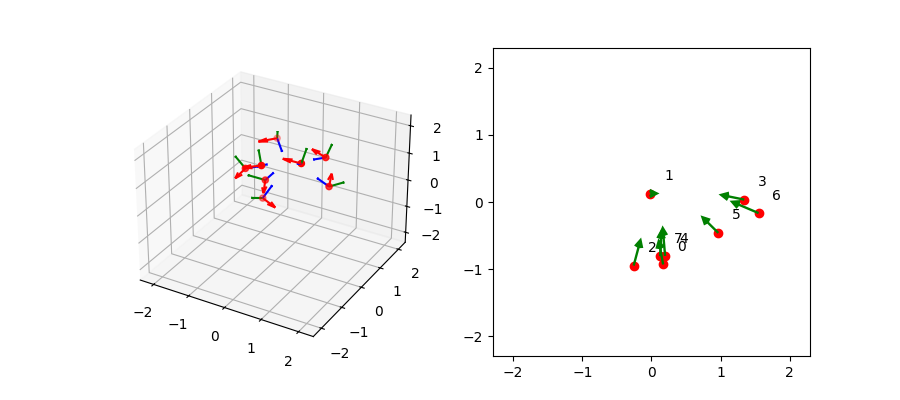

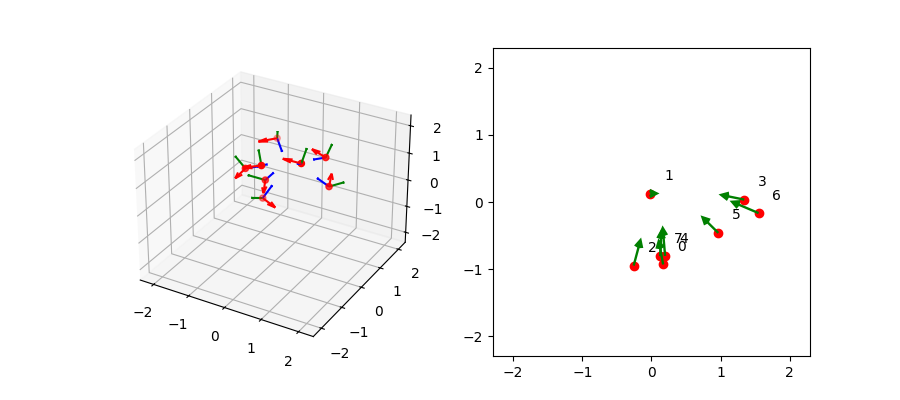

In [51]:
%matplotlib widget

subject_id = "m003"
command = (Calibration & 'recording_base LIKE "%20240124_1409%"')
# prm = (Calibration&(CalibratedRecording*Recording &f'participant_id="{subject_id}"')).fetch1('camera_calibration')
# cals = (Calibration&((SingleCameraVideo & f'filename LIKE"{subject_id}%"'))).fetch('camera_calibration')
prm = (command).fetch1('camera_calibration')
cals = (command).fetch('camera_calibration')
plot_cal(cals[0])

plt.show()

In [ ]:
# %%bash
cd ~/notebooks/mmpose/MultiCameraTracking
CUDA_VISIBLE_DEVICES=0 python -m multi_camera.datajoint.calibrate_cameras --checkerboard_size=35 --checkerboard_dim=6,5 /mnt/CottonLab/mobile_system_data/20240227/m005/calibration_20240227_152020

In [31]:
keys = (HandPoseEstimation & (Recording & f'participant_id="m003"') & 'estimation_method=0' & 'detection_method=1').fetch('KEY')[:8]
key = keys[0]
key["reconstruction_method"] = 3

In [32]:
import numpy as np
from multi_camera.analysis.camera import robust_triangulate_points, triangulate_point
from multi_camera.analysis.optimize_reconstruction import  reprojection_loss, smoothness_loss        
calibration_key = cal_key
recording_key = (MultiCameraRecording & key).fetch1("KEY")
reconstruction_method = key["reconstruction_method"]
estimation_method = key["estimation_method"]
detection_method = key["detection_method"]
camera_calibration, camera_names = (Calibration & calibration_key).fetch1("camera_calibration", "camera_names")
keypoints, camera_name = (
    HandPoseEstimation * SingleCameraVideo * MultiCameraRecording
    & {
        "estimation_method": estimation_method,
        "detection_method" : detection_method,
        "reconstruction_method": reconstruction_method,
    }
    & recording_key
).fetch("keypoints_2d", "camera_name")

In [34]:
N = max([len(k) for k in keypoints])
keypoints = np.stack(
    [np.concatenate([k, np.zeros([N - k.shape[0], *k.shape[1:]])], axis=0) for k in keypoints], axis=0
)
print('Triangulating over ', len(camera_names))
# work out the order that matches the calibration (should normally match)
order = [list(camera_name).index(c) for c in camera_names]
points2d = np.stack([keypoints[o][:, :, :] for o in order], axis=0)


# select method for reconstruction
reconstruction_method_name = (HandPoseReconstructionMethodLookup & key).fetch1(
    "reconstruction_method_name"
)
reconstruction_method_name

Triangulating over  8


'Robust Triangulation $\\\\gamma=0.3$'

In [35]:
points3d, camera_weights = robust_triangulate_points(
                camera_calibration, points2d, return_weights=True, threshold=0.3
            )

CUDA backend failed to initialize: Found cuDNN version 8700, but JAX was built against version 8906, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [38]:
key["reprojection_loss"] = reprojection_loss(camera_calibration, points2d, points3d[:, :, :3], huber_max=100)
key["reprojection_loss"]

Array(16.505915, dtype=float32)

In [47]:
results = plot_osim_triangulated_keypoints(keys, points3d, frame_index = -1)

100%|██████████| 180/180 [00:04<00:00, 39.09it/s]


In [74]:
CalibratedRecording & key

recording_timestamps,camera_config_hash,cal_timestamp
2024-01-24 14:14:11,10d8a3c714,2024-01-24 14:04:02
2024-01-24 14:14:11,10d8a3c714,2024-01-24 14:30:40


In [71]:

missing = (MultiCameraRecording & 'video_project IN ("HAND_TEST")' & 'video_base_filename LIKE "%20240124%"')
calibration_offset = (Calibration * MultiCameraRecording).proj(calibration_offset = 'ABS(recording_timestamps-cal_timestamp)')
#calibration_offset = (Calibration * MultiCameraRecording).proj(calibration_offset = '(recording_timestamps-cal_timestamp)')

# only accept low reprojection errors
# calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.7' & 'cal_timestamp LIKE "2024-03-08 13:44%"')
calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.2' & 'cal_timestamp LIKE "2024-01-24 14:30%"')
# calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.23' & 'cal_timestamp LIKE "2024-03-08 17%"')
# calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.5' & 'cal_timestamp LIKE "2024-03-08 12:56:14%"' )
#calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error > 0.21 and reprojection_error < 5' )

# find closest calibrations to an experiment
viable = missing.aggr(calibration_offset, min_calibration_offset='MIN(calibration_offset)') & 'min_calibration_offset < 750000'
viable = viable.proj(calibration_offset='min_calibration_offset')
matches = calibration_offset & viable.fetch(as_dict=True) 
display(Calibration & (MultiCameraRecording * matches))
CalibratedRecording.insert((matches).fetch("KEY"), skip_duplicates=True)

cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type
2024-01-24 14:30:40,10d8a3c714,calibration_20240124_143040,8,=BLOB=,=BLOB=,0.162555,=BLOB=,=BLOB=,None


In [17]:
# this shouldn't be needed but checks for any sessions that need to be calibrated

# find the calibration that is closest in time to each recording that also has a minimum
# threshold. note that this will possibly allow different calibrations within a session,
# but this is intentional to also handle using different camera setups in a session

missing = (MultiCameraRecording & Recording - CalibratedRecording).proj()
missing = missing & (MultiCameraRecording & 'video_project IN ("HAND_TEST")')

# TODO: fix data from Aug 8. not clear if it is the calibration or the images
missing = missing - (MultiCameraRecording & 'video_base_filename LIKE "%20230808%"')

# skip experiments upstairs
#missing = missing - 'camera_config_hash="1f4f00bed6"'

#missing = missing & (MultiCameraRecording & 'video_base_filename LIKE "p624%"')

calibration_offset = (Calibration * MultiCameraRecording).proj(calibration_offset = 'ABS(recording_timestamps-cal_timestamp)')
#calibration_offset = (Calibration * MultiCameraRecording).proj(calibration_offset = '(recording_timestamps-cal_timestamp)')

# only accept low reprojection errors
# calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.7' & 'cal_timestamp LIKE "2024-03-08 13:44%"')
calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.2' & 'cal_timestamp LIKE "2024-03-09 12%"')
# calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.23' & 'cal_timestamp LIKE "2024-03-08 17%"')
# calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error < 0.5' & 'cal_timestamp LIKE "2024-03-08 12:56:14%"' )
#calibration_offset = calibration_offset & ( Calibration  & 'reprojection_error > 0.21 and reprojection_error < 5' )

# find closest calibrations to an experiment
viable = missing.aggr(calibration_offset, min_calibration_offset='MIN(calibration_offset)') & 'min_calibration_offset < 750000'
#'min_calibration_offset > 30000 and min_calibration_offset < 50000'

# need to awkwardly use the fetch at end to join on dependent attributes. this is basically performing an
# argmin operation
viable = viable.proj(calibration_offset='min_calibration_offset')
matches = calibration_offset & viable.fetch(as_dict=True) 

# display(MultiCameraRecording * matches & "recording_timestamps > '2024-03-08 14:00:00' AND recording_timestamps LIKE '2024-03-08%'")

display(Recording * MultiCameraRecording * missing & 'participant_id != "32"')
#display(Subject & (Recording * MultiCameraRecording * matches))
display(Calibration & (MultiCameraRecording * matches))
display(Recording * MultiCameraRecording * matches)
#display(Subject & (Recording * MultiCameraRecording * missing - matches))
#display(Recording * MultiCameraRecording * missing - matches) 
# display(matches)
# CalibratedRecording.insert((matches  & "recording_timestamps > '2024-03-08 14:00:00' AND recording_timestamps LIKE '2024-03-08%'").fetch("KEY"), skip_duplicates=True)
#CalibratedRecording.insert((matches).fetch("KEY"), skip_duplicates=True)

participant_id,session_date,recording_timestamps,camera_config_hash,comment,video_project,video_base_filename
m003,2024-01-11,2024-01-11 12:22:02,9e22c563de,,HAND_TEST,m003_static_20240111_122202
m003,2024-01-11,2024-01-11 12:23:02,9e22c563de,,HAND_TEST,m003_ball_20240111_122302
m003,2024-01-11,2024-01-11 12:26:33,9e22c563de,,HAND_TEST,m003_tape_20240111_122633
m003,2024-01-11,2024-01-11 12:27:50,9e22c563de,,HAND_TEST,m003_extra_hands_20240111_122750
m003,2024-01-11,2024-01-11 12:28:44,9e22c563de,,HAND_TEST,m003_random_20240111_122844
m003,2024-01-11,2024-01-11 12:30:08,9e22c563de,,HAND_TEST,m003_occluding_fingers_20240111_123008


cal_timestamp,camera_config_hash,recording_base,num_cameras,camera_names list of camera names,camera_calibration calibration results,reprojection_error,calibration_points,calibration_shape,calibration_type


participant_id,session_date,recording_timestamps,camera_config_hash,cal_timestamp,comment,video_project,video_base_filename,calibration_offset calculated attribute


In [19]:
missing.aggr(calibration_offset, min_calibration_offset='MIN(calibration_offset)') & 'min_calibration_offset < 750000'


recording_timestamps,camera_config_hash,min_calibration_offset calculated attribute


recording_timestamps,camera_config_hash
2022-03-03 06:27:24,38fb7061ed
2022-05-06 07:15:04,38fb7061ed
2022-05-06 07:18:06,38fb7061ed
2022-05-06 07:21:29,38fb7061ed
2022-05-06 07:24:02,38fb7061ed
2022-05-06 07:27:59,38fb7061ed
2022-05-06 07:29:41,38fb7061ed
2022-05-06 07:30:35,38fb7061ed
2022-05-06 07:32:03,38fb7061ed
2022-05-06 07:34:02,38fb7061ed


In [3]:
#Choose first 3 recordings
import datetime
date_to_restrict = datetime.datetime(2024, 1, 24)
# (Recording * SingleCameraVideo) & "video_project='CUET'" & f'recording_timestamps>"{date_to_restrict}"'
participant_videos = (Recording & 'participant_id="m003"' & f'recording_timestamps>="{date_to_restrict}"').fetch('KEY')#[:-1]#[participant_idx]
vid_keys= (SingleCameraVideo & participant_videos & "filename NOT LIKE '%object%'").fetch('KEY')
len(vid_keys)
TopDownPerson & vid_keys

video_project,filename,tracking_method,video_subject_id,top_down_method,keypoints
HAND_TEST,m003_hand_augmented_20240124_141948.23106523,21,0,2,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106523,21,0,12,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106526,21,0,2,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106526,21,0,12,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106529,21,0,2,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106529,21,0,12,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106533,21,0,2,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106533,21,0,12,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106539,21,0,2,=BLOB=
HAND_TEST,m003_hand_augmented_20240124_141948.23106539,21,0,12,=BLOB=


In [12]:
keys = (TopDownPerson & vid_keys & 'top_down_method=12' & 'filename LIKE "%_static%"').fetch('KEY')


In [26]:
from pose_pipeline.pipeline import TopDownPersonVideo

# TopDownPersonVideo.populate(keys)
(TopDownPersonVideo & keys[0]).fetch('output_video')

array(['tmp3w6n6pwp.mp4'], dtype=object)

In [5]:
k = (PersonKeypointReconstruction & (SingleCameraVideo & vid_keys & keys) & 'top_down_method=12').fetch('KEY')

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9e8c307790>>
Traceback (most recent call last):
  File "/home/jd/.conda/envs/mjx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9e8c307790>>
Traceback (most recent call last):
  File "/home/jd/.conda/envs/mjx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-framerate', '29.08', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-b', '500000k', '-y', '/tmp/tmppi09dxtg.mp4']' returned non-zero exit status 255.

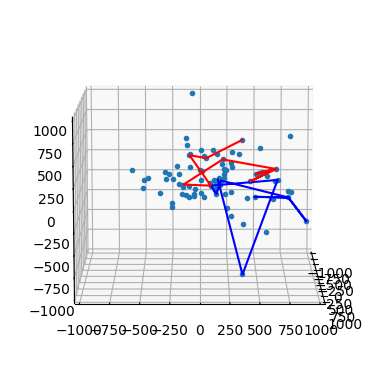

In [22]:
PersonKeypointReconstructionVideo.populate(k)

In [20]:
(PersonKeypointReprojectionVideo & k).fetch('output_video')

array([], dtype=object)

In [21]:
PersonKeypointReconstruction & (SingleCameraVideo & vid_keys & keys) & 'top_down_method=12'

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,tracking_method,top_down_method,keypoints3d,camera_weights,reprojection_loss,skeleton_loss,smoothness_loss
2024-01-24 14:19:48,10d8a3c714,2024-01-24 14:30:40,2,21,12,=BLOB=,=BLOB=,150.3,30.7415,33.7389


[2024-05-15 18:21:54,617][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2024-05-15 18:21:54,713][INFO]: Connected pfirouzabadi@127.0.0.1:3306


NameError: name 'k' is not defined

In [17]:
k = (HandPoseReconstruction & (SingleCameraVideo & vid_keys & 'filename LIKE "%_static%"' )).fetch('KEY')

In [21]:
from hand_detection.hand_dj import MJXReconstructionVideo,MJXReconstructionAnalysis,HandBboxMethodLookup,HandPoseReconstructionVideo
HandPoseReconstructionVideo.populate(k)

KeyboardInterrupt: 

In [20]:
(HandPoseReconstructionVideo & k).delete()

[2024-05-15 18:26:45,796][INFO]: Deleting 1 rows from `hand_detection`.`__hand_pose_reconstruction_video`
[2024-05-15 18:26:49,971][INFO]: Deletes committed.


1